In [ ]:
import numpy as np
import pandas as pd
import random
import math

# --------------- KiTE Imports ---------------
from KiTE.metrics import ELCE2
from KiTE.calibrate import calibrate, calibration_error
from KiTE.calibration_models import EWF_calibration, KRR_calibration

# --------------- Visualization Imports ---------------
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

plt.style.use("tableau-colorblind10")
# sns.set()

# --------------- Model Imports ---------------
from scipy import stats
from sklearn.calibration import calibration_curve
from sklearn.metrics import pairwise_distances, pairwise_kernels, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    Ridge,
)
from sklearn.pipeline import make_pipeline

In [ ]:
import numpy as np
from sklearn.gaussian_process.kernels import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from netcal.scaling import TemperatureScaling, BetaCalibration
from netcal.binning import HistogramBinning, BBQ, ENIR
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from KiTE.calibration_models import KRR_calibration, EWF_calibration
from KiTE.validation import check_attributes, check_credible_vector_args

In [ ]:
from pmc import MultiCalibrator, Auditor

In [ ]:
from matplotlib.ticker import FormatStrFormatter

# Load Data
* COMPAS Data can be found at [this source](https://github.com/propublica/compas-analysis/blob/master/compas.db)
* We use Broward Data from 2013 - 2014, inclusive.

In [ ]:
def load_recidivism_data(file_name="/Users/ritwikvashistha/Downloads/BROWARD_ORIGINAL.csv"):
    df = pd.read_csv(file_name)[
        [
            "sex",
            "age",
            "race",
            "juv_fel_count",
            "juv_misd_count",
            "priors_count",
            "c_charge_degree",
            "is_recid",
        ]
    ]

    df["c_charge_degree"].replace(["F", "M"], [0, 1], inplace=True)
    df["sex"].replace(["Male", "Female"], [0, 1], inplace=True)
    df["age"] /= 10.0

    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df["race"])

    # Drop column B as it is now encoded
    df = df.drop("race", axis=1)

    # Join the encoded df
    df = df.join(one_hot)

    return df

In [ ]:
df = load_recidivism_data()
df

,sex,age,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_recid,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,0,6.9,0,0,0,0,0,False,False,False,False,False,True
1,0,3.4,0,0,0,0,1,True,False,False,False,False,False
2,0,2.4,0,0,4,0,1,True,False,False,False,False,False
3,0,2.3,0,1,1,0,0,True,False,False,False,False,False
4,0,4.3,0,0,2,0,0,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,2.3,0,0,0,0,0,True,False,False,False,False,False
7210,0,2.3,0,0,0,0,0,True,False,False,False,False,False
7211,0,5.7,0,0,0,0,0,False,False,False,False,False,True
7212,1,3.3,0,0,3,1,0,True,False,False,False,False,False


# Build Random Forest Classification Model
* Split data into train-validate-test disjoint sets
    * Train -- Used to train the Random Forest Classifier
    * Validate -- Used to train model calibration
    * Test -- Used to test group-wise trustworthiness

In [ ]:
def build_model(df):
    features = [
        "age",
        "sex",
        "African-American",
        "juv_fel_count",
        "juv_misd_count",
        "priors_count",
        "c_charge_degree",
        "Asian",
        "Caucasian",
        "Hispanic",
        "Native American",
        "Other",
    ]
    fair_features = ["age", "sex", "African-American"]
    target = "is_recid"

    # Split data into train, validate and test data
    train, validate, test = np.split(
        df.sample(frac=1), [int(0.33 * len(df)), int(0.66 * len(df))]
    )

    X_train = np.array(train[features])
    X_cv = np.array(validate[features])
    X_test = np.array(test[features])

    X_train_fair = np.array(train[fair_features])
    X_cv_fair = np.array(validate[fair_features])
    X_test_fair = np.array(test[fair_features])

    y_train = np.array(train[target])
    y_cv = np.array(validate[target])
    y_test = np.array(test[target])

    # Train the Random Forest model on the 1st subset of data (training set)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    prob_test = clf.predict_proba(X_test)[:, 1]
    prob_cv = clf.predict_proba(X_cv)[:, 1]

    return X_test, X_test_fair, y_test, X_cv, X_cv_fair, y_cv, prob_test, prob_cv, clf

In [ ]:

def _counts_per_bin(prob, n_bins):
    """
    Taken from https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/calibration.py#L513
    """

    bins = np.linspace(0.0, 1.0 + 1e-8, n_bins + 1)
    binids = np.digitize(prob, bins) - 1
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    return bin_total[nonzero]

def calibration_error(y_true, y_prob, n_bins=10, method="ECE"):
    """
    Compute calibration error given true targets and predicted probabilities.
     Calibration curves may also be referred to as reliability diagrams.

    Parameters
    ----------
    y_true : array, shape (n_samples,)
        True targets.

    y_prob : array, shape (n_samples,)
        Probabilities of the positive class.

    method : string, default='ECE', {'ECE', 'MCE', 'BS'}
        Which method to be used to compute calibration error.

    n_bins : int
        Number of bins. Note that a bigger number requires more data.

    Returns
    -------
    float
        calibration error score
    """

    # compute fraction of positive cases per y_prob in a bin.
    # See scikit-learn documentation for details
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy="uniform"
    )

    if method == "ECE":
        hist_count = _counts_per_bin(y_prob, n_bins)
        return np.sum(
            hist_count * np.abs(fraction_of_positives - mean_predicted_value)
        ) / np.sum(hist_count)
    elif method == "MCE":
        return np.max(np.abs(fraction_of_positives - mean_predicted_value))
    elif method == "BS":
        return brier_score_loss(y_true, y_prob, pos_label=1)
    else:
        raise ValueError("Method %s is not defined." % method)

In [ ]:
calibrate(X_test_fair,
            prob_test,
            y_test,
            X_test=X_cv_fair,
            prob_test=prob_cv,method="MC")

In [ ]:
calibrate( X_cv,
            prob_cv,
            y_cv,
            Xtest=X_test,
            prob_test=prob_test,
            method="MC")

In [ ]:
def calibrate(
    Xtrain, prob_train, Ytrain, Xtest=None, prob_test=None, method="platt", **kwargs
):
    """
    A calibration method that takes the predicted probabilties and positive cases and recalibrate the probabilities.

    Parameters
    ----------
    Xtrain : array, shape (n_samples_train,)
        Features used for training

    prob_train : array, shape (n_samples_train,)
        Probabilities of positive class to train a calibration model

    Ytrain : array, shape (n_samples_train,)
        Values used for training

    Xtest : array, shape (n_samples_test,)
        Features used for testing

    prob_test : array, shape (n_samples_test,)
        Probabilities of the positive class to be calibrated (test set). If None it re-calibrate the training set.

    method: string, 'platt', 'isotonic', 'temperature_scaling', 'beta', 'HB', 'BBG', 'ENIR'
        The method to use for calibration. Can be ‘sigmoid’ which corresponds to Platt’s method
        (i.e. a logistic regression model) or ‘isotonic’ which is a non-parametric approach.
        It is not advised to use isotonic calibration with too few calibration samples (<<1000) since it tends to overfit.

    **kwargs
        Additional Args used to fit KRR or EWF

    Returns
    -------
    array, shape (n_bins,)
        The calibrated error for test set. (p_calibrated)

    """
    probs = prob_train[:, np.newaxis] if prob_test is None else prob_test[:, np.newaxis]
    Xtest = Xtrain if Xtest is None else Xtest

    if method == "platt":
        model = LogisticRegression()
        model.fit(prob_train[:, np.newaxis], Ytrain)  # LR needs X to be 2-dimensional
        p_calibrated = model.predict_proba(probs)[:, 1]

    elif method == "isotonic":
        model = IsotonicRegression(out_of_bounds="clip")
        model.fit(prob_train, Ytrain)  # LR needs X to be 2-dimensional
        p_calibrated = model.transform(probs.flatten())

    elif method == "temperature_scaling":
        model = TemperatureScaling()
        model.fit(prob_train, Ytrain)
        p_calibrated = model.transform(probs)

    elif method == "beta":
        model = BetaCalibration()
        model.fit(prob_train, Ytrain)
        p_calibrated = model.transform(probs)

    elif method == "HB":
        model = HistogramBinning()
        model.fit(prob_train, Ytrain)
        p_calibrated = model.transform(probs)

    elif method == "BBQ":
        model = BBQ()
        model.fit(prob_train, Ytrain)
        p_calibrated = model.transform(probs)

    elif method == "ENIR":
        model = ENIR()
        model.fit(prob_train, Ytrain)
        p_calibrated = model.transform(probs)

    elif method == "KRR":
        model = KRR_calibration()
        model.fit(Xtrain, prob_train, Ytrain, **kwargs)
        p_calibrated = model.predict(Xtest, probs.flatten(), mode="prob")

    elif method == "EWF":
        model = EWF_calibration()
        model.fit(Xtrain, prob_train, Ytrain, **kwargs)
        p_calibrated = model.predict(Xtest, probs.flatten(), mode="prob")

    # elif method == "MC":
    #    estimator = RandomForestClassifier()
    #    est = MultiCalibrator(estimator = estimator, auditor_type = Auditor(groups=[0,1,2],metric="MC"))
    #    est.fit(pd.DataFrame(Xtrain),Ytrain)
    #    p_calibrated =est.predict_proba(pd.DataFrame(Xtest))[:, 1]

    else:
        raise ValueError("Method %s is not defined." % method)

    p_calibrated[np.isnan(p_calibrated)] = 0

    # normalize the large numbers and small numbers to one and zero
    # p_calibrated[p_calibrated > 1.0] = 1.0
    # p_calibrated[p_calibrated < 0.0] = 0.0

    return p_calibrated  # f-hat -- f(x) = oracle = f-hat + b(x)


In [ ]:
(
    X_test,
    X_test_fair,
    y_test,
    X_cv,
    X_cv_fair,
    y_cv,
    prob_test,
    prob_cv,
    clf,
) = build_model(df)

/Users/ritwikvashistha/anaconda3/envs/fernando/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Compare Calibration Methods

In [ ]:
def plot_metrics(
    X_test,
    prob_test,
    y_test,
    X_cv,
    prob_cv,
    y_cv,
    method,
    ax1,
    ax2,
    ax3,
    ax4,
    ax5,
    ax6,
    legend=None,
    n_bins=20,
    prob_kernel_wdith=0.05,
    gamma=0.5,
    marker="^",
    markersize=14,
    multiplier=100.0,
    markeredgewidth=2,
    data=False,
    **kwargs
):

    import time

    # ------------- RUN CALIBRATION -------------
    prob_cal = (
        prob_test.copy()
        if method == "No calibration"
        else calibrate(
            X_cv,
            prob_cv,
            y_cv,
            Xtest=X_test,
            prob_test=prob_test,
            method=method,
            gamma=gamma,
        )
        if method == "EWF" or method == "KRR"
        else calibrate(
            X_cv,
            prob_cv,
            y_cv,
            Xtest=X_test,
            prob_test=prob_test,
            method=method,
            **kwargs
        )
    )

    X_test = X_test[0 <= prob_cal]
    y_test = y_test[0 <= prob_cal]
    prob_cal = prob_cal[0 <= prob_cal]

    X_test = X_test[1 >= prob_cal]
    y_test = y_test[1 >= prob_cal]
    prob_cal = prob_cal[1 >= prob_cal]

    # ------------- MAKE CALIBRATION CURVE + CREATE SCORES -------------
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_cal, n_bins=n_bins
    )
    BS_score = calibration_error(y_test, prob_cal, n_bins=n_bins, method="BS")
    ece_score = calibration_error(y_test, prob_cal, n_bins=n_bins, method="ECE")
    mce_score = calibration_error(y_test, prob_cal, n_bins=n_bins, method="MCE")

    start_time = time.time()
    if data:
        ELCE2_ = ELCE2(
            X_test,
            y_test,
            prob_cal,
            prob_kernel_width=prob_kernel_wdith,
            kernel_function="rbf",
            gamma=gamma,
            iterations=None,
            verbose=False,
        )
    else:
        ELCE2_, _, pvalue = ELCE2(
            X_test,
            y_test,
            prob_cal,
            kernel_function="rbf",
            prob_kernel_width=prob_kernel_wdith,
            iterations=1000,
            verbose=True,
            gamma=gamma,
        )
    print("--- TIME_TAKEN = %s seconds ---" % (time.time() - start_time))

    if data:
        return BS_score, ece_score, mce_score, ELCE2_

    if pvalue > 0.49:
        pvalue = 0.49
    if ELCE2_ < 0.0:
        ELCE2_ = -0.00005

    # ------------- GENERATE PLOT -------------
    ax1.plot(
        mean_predicted_value,
        fraction_of_positives,
        "%s-" % marker,
        markersize=markersize - 6,
        lw=3.0,
        label=legend,
    )
    ax2.plot(
        BS_score, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth
    )
    ax3.plot(
        ece_score, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth
    )
    ax4.plot(
        mce_score, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth
    )
    ax5.plot(ELCE2_, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth)
    ax6.plot(pvalue, 1, marker, markersize=markersize, markeredgewidth=markeredgewidth)

    print(
        legend
        + " "
        + method
        + " BS : %0.3f " % BS_score
        + " ECE : %0.3f " % ece_score
        + " MCE : %0.3f " % mce_score
        + " KLCE2 : %0.3f" % (ELCE2_)
    )
    time.sleep(1)

In [ ]:
# Trains the model
def predicting_recidivism_callib(df):
    np.random.seed(1864)

    (
        X_test,
        X_test_fair,
        y_test,
        X_cv,
        X_cv_fair,
        y_cv,
        prob_test,
        prob_cv,
        clf,
    ) = build_model(df)

    # kernel hyperparameter
    gamma = 0.5  # np.median(pairwise_distances(X_test, metric='euclidean')) ** 2

    # error calibration setup
    n_bins = 20

    # #############################################################################
    # Plot calibration plots
    methods = [
        "No calibration",
        "platt",
        "temperature_scaling",
        "isotonic",
        "BBQ"
    ]

    l_methods = len(methods)
    plt.figure(figsize=(l_methods * 6, 13))

    for i, method in enumerate(methods):

        ax1 = plt.subplot2grid((9, l_methods * 1), (0, i), rowspan=4)
        ax2 = plt.subplot2grid((9, l_methods * 1), (4, i))
        ax3 = plt.subplot2grid((9, l_methods * 1), (5, i))
        ax4 = plt.subplot2grid((9, l_methods * 1), (6, i))
        ax5 = plt.subplot2grid((9, l_methods * 1), (7, i))
        ax6 = plt.subplot2grid((9, l_methods * 1), (8, i))

        ax1.plot([0, 1], [0, 1], "k:", label="reference")

        plot_metrics(
            X_test_fair,
            prob_test,
            y_test,
            X_cv_fair,
            prob_cv,
            y_cv,
            method,
            ax1,
            ax2,
            ax3,
            ax4,
            ax5,
            ax6,
            legend="Recidivism Pred.",
            n_bins=20,
            prob_kernel_wdith=0.1,
            gamma=gamma,
            marker="^",
            markersize=18,
            markeredgewidth=2,
        )

        ax1.set_xlabel("Mean predicted value", size=24)
        ax1.set_ylim([0.0, 1.0])
        ax1.set_xlim([0.0, 1.0])
        ax1.tick_params(axis='y', labelsize=28)
        ax1.tick_params(axis='x', labelsize=28)
        ax1.set_yticks([])
        ax1.set_title(method, size=30)
        ax1.grid()

        ax2.set_yticks([])
        ax2.tick_params(axis='x', labelsize=28)
        ax2.set_xlim([0.0, 0.5])
        ax3.set_yticks([])
        ax3.tick_params(axis='x', labelsize=28)
        ax3.set_xlim([0, 0.1])
        ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax4.set_yticks([])
        ax4.tick_params(axis='x', labelsize=28)
        ax4.set_xlim([0, 0.4])
        ax5.set_yticks([])
        ax5.set_xlim([-0.0005, 0.042])
        ax5.tick_params(axis='x', labelsize=28)
        ax6.set_yticks([])
        ax6.set_xlim([-0.01, 0.5])
        ax6.tick_params(axis='x', labelsize=28)

        if i == 0:
            ax1.set_ylabel("Fraction of positives", size=24)
            ax1.legend(loc="upper left", prop={"size": 18})
            ax1.tick_params(axis='y', labelsize=28)
            ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
            ax1.tick_params(axis='x', labelsize=28)
            ax2.set_ylabel("BS",  labelpad= 20, size=27)
            ax2.tick_params(axis='x', labelsize=28)
            ax3.set_ylabel("ECE",  labelpad= 20,size=27)
            ax3.tick_params(axis='x', labelsize=28)
            ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax4.set_ylabel("MCE", labelpad= 20, size=27)
            ax4.tick_params(axis='x', labelsize=28)
            ax5.set_ylabel(r"$\widehat{KLCE^2}$",  labelpad= 20 ,size=24)
            ax5.tick_params(axis='x', labelsize=28)
            ax6.set_ylabel(r"p-val", labelpad= 20,size=28)
            ax6.tick_params(axis='x', labelsize=28)


    plt.tight_layout()
    plt.savefig("./NEW_recidivism_test.png")
    plt.show()

/Users/ritwikvashistha/anaconda3/envs/fernando/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


--- TIME_TAKEN = 14.207314252853394 seconds ---
Recidivism Pred. No calibration BS : 0.262  ECE : 0.160  MCE : 0.269  KLCE2 : 0.032
--- TIME_TAKEN = 13.538813352584839 seconds ---
Recidivism Pred. platt BS : 0.231  ECE : 0.022  MCE : 0.037  KLCE2 : 0.003
--- TIME_TAKEN = 13.150534868240356 seconds ---
Recidivism Pred. temperature_scaling BS : 0.241  ECE : 0.091  MCE : 0.207  KLCE2 : 0.005
--- TIME_TAKEN = 13.264870882034302 seconds ---
Recidivism Pred. isotonic BS : 0.231  ECE : 0.018  MCE : 0.046  KLCE2 : 0.002


100%|███████████████████████████████████████| 134/134 [00:00<00:00, 3142.73it/s]


--- TIME_TAKEN = 13.643759965896606 seconds ---
Recidivism Pred. BBQ BS : 0.232  ECE : 0.009  MCE : 0.027  KLCE2 : 0.003


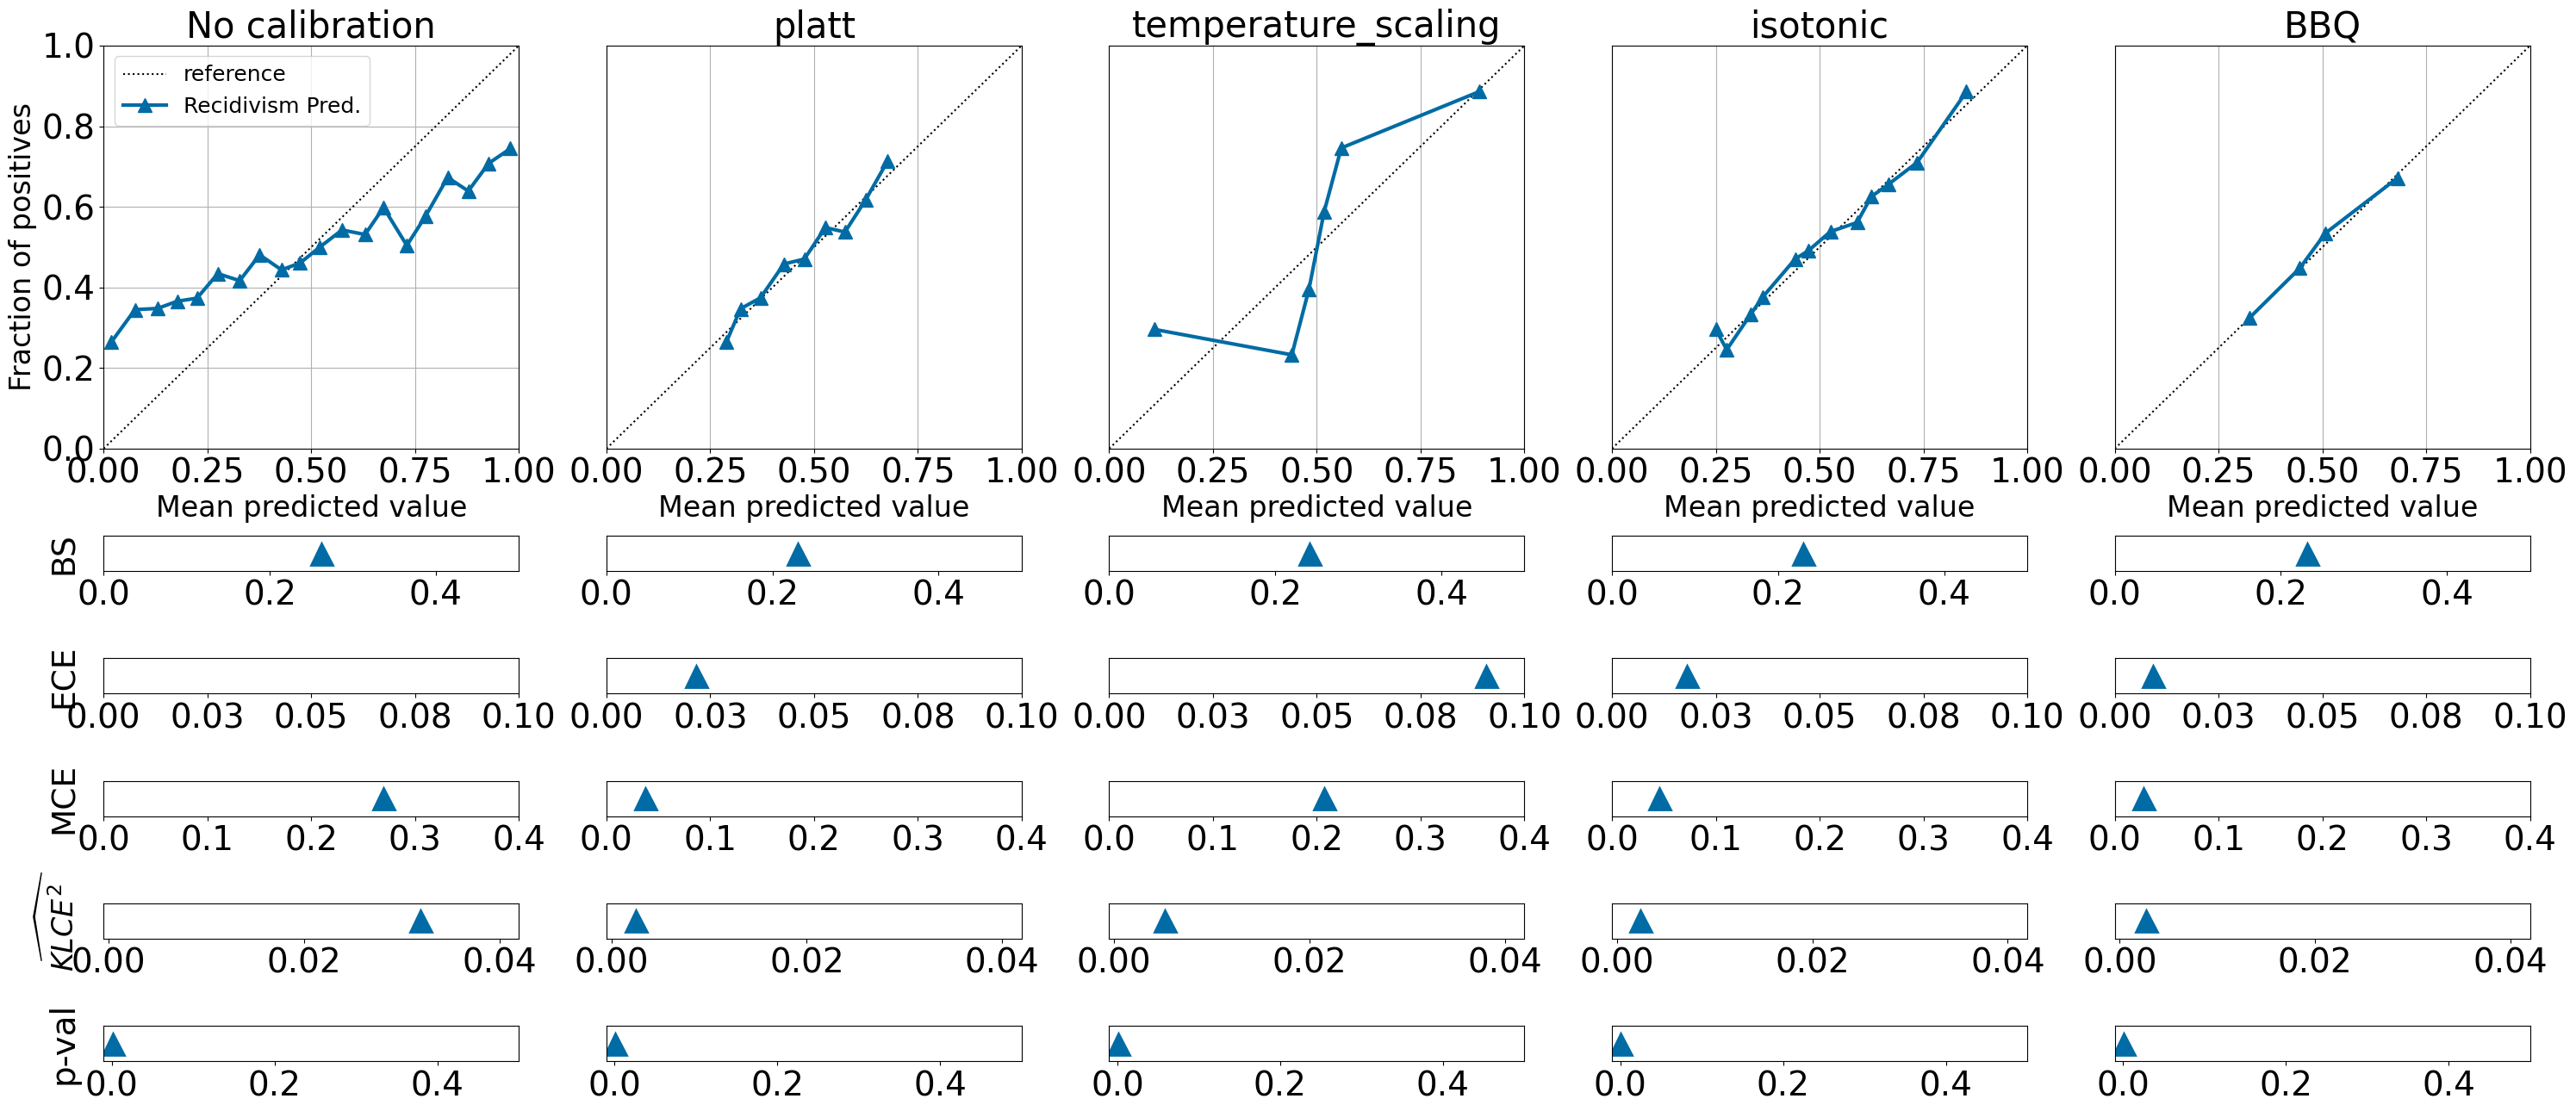

In [ ]:
predicting_recidivism_callib(df)

# Plot EWF Estimated Bias

In [ ]:
def predicting_recidivism():
    np.random.seed(1864)

    (
        X_test,
        X_test_fair,
        y_test,
        X_cv,
        X_cv_fair,
        y_cv,
        prob_test,
        prob_cv,
        clf,
    ) = build_model(df)

    # kernel hyperparameter
    gamma = 0.5

    # error calibration setup
    n_bins = 20
    kmax = 1
    ewf_model = EWF_calibration()

    # #############################################################################
    #                             Plot calibration plots
    # #############################################################################
    def plot_ewf(X_cv, y_cv, prob_cv, X_test, prob_test, ax, color="blue", label=None):
        # Train a calibration method (EWF) on 2nd data subset
        ewf_model.fit(X_cv, prob_cv, y_cv, kernel_function="rbf", gamma=gamma)
        ewf = ewf_model.predict(X_test, prob_test, mode="bias")

        # Plot outcome
        ax.plot(
            X_test.T[0] * 10 + 0.3 * (np.random.random() - 0.5), ewf, ".", color=color
        )

        Xfit = X_test.T[0] * 10
        model = make_pipeline(PolynomialFeatures(3), Ridge())
        model.fit(Xfit[:, np.newaxis], ewf)

        X_plot = np.linspace(20, 70, 201)
        y_plot = model.predict(X_plot[:, np.newaxis])

        ax.plot(X_plot, y_plot, lw=5, color=color, label=label)
        return ax

    plt.figure(figsize=(2 * 7, 6))
    ax = plt.subplot2grid((2, 2), (0, 0))
    ax.plot([20.0, 70.0], [0, 0], "k-", label="reference")

    mask = X_test_fair.T[1] == 0
    mask *= X_test_fair.T[2] == 1
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#377eb8",
        label="Male",
    )

    mask = X_test_fair.T[1] == 1
    mask *= X_test_fair.T[2] == 1
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#f781bf",
        label="Female",
    )

    ax.set_ylim([-0.1, 0.1])
    plt.yticks([-0.1, -0.05, 0, 0.05, 0.1], ["-0.1", "-0.05", "0", "0.05", "0.1"])
    ax.set_xlim([20, 70.0])

    ax.set_title(r"African-American", size=24, color="indianred")
    ax.set_ylabel("Local Calibration Bias", size=24)
    ax.set_xlabel(r"Age [years]", size=24)

    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.tick_params(axis="both", which="minor", labelsize=15)
    ax.legend(loc="upper right", prop={"size": 12})

    ax.grid()
    ax = plt.subplot2grid((2, 2), (0, 1))
    ax.plot([21.0, 70.0], [0, 0], "k-", label="reference")

    mask = X_test_fair.T[1] == 0
    mask *= X_test_fair.T[2] == 0
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#377eb8",
        label="Male",
    )

    mask = X_test_fair.T[1] == 1
    mask *= X_test_fair.T[2] == 0
    ax = plot_ewf(
        X_cv_fair,
        y_cv,
        prob_cv,
        X_test_fair[mask],
        prob_test[mask],
        ax,
        color="#f781bf",
        label="Female",
    )

    ax.set_ylim([-0.1, 0.1])
    plt.yticks([-0.1, -0.05, 0, 0.05, 0.1], 5 * [""])
    ax.set_xlim([20, 70.0])

    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.tick_params(axis="both", which="minor", labelsize=15)

    ax.set_xlabel(r"Age [years]", size=25)
    ax.set_title(r"Non-African-American", size=25, color="indianred")

    ax.grid()

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.savefig("./NEW_recidivism_test_bias.png", bbox_inches="tight")
    plt.show()

/Users/ritwikvashistha/anaconda3/envs/fernando/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


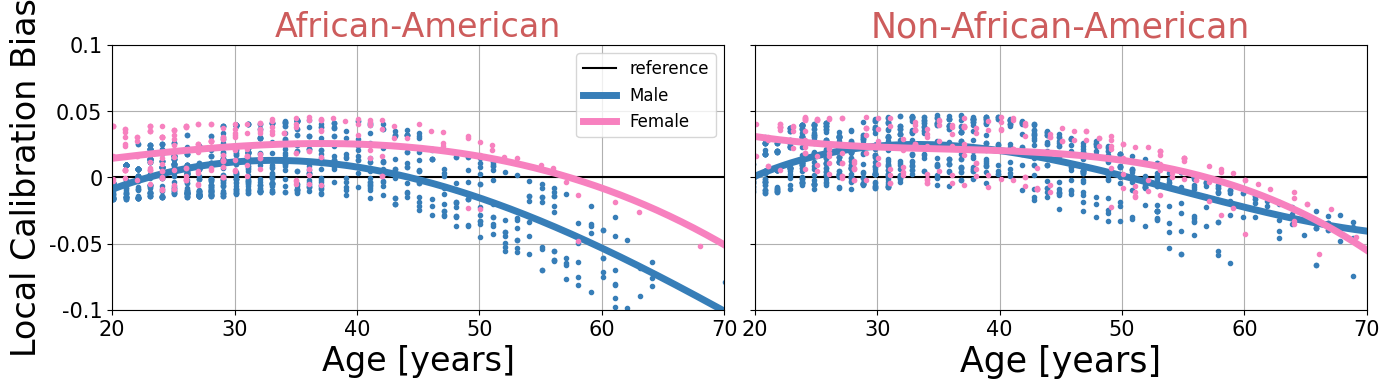

In [ ]:
predicting_recidivism()